# Creating a frequency finder auto-encoder

## Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import callbacks
import tensorflow.keras as keras
from tensorflow.keras import layers
import umap
from babyplots import Babyplot
#import hdbscan
from matplotlib import pyplot
from models import *
from converters import *
from helpers import *
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

2021-10-06 21:12:12.515490: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-06 21:12:12.515506: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%load_ext autoreload
%autoreload 2

## Get drive path 

In [3]:
#drive_path = find_drive_path()
#drive_path

## Load Data from drive

In [4]:
try:
    data = pd.read_pickle(f"{drive_path}/Data/Inputs/Synthetisch/Syn_tot.pkl")
except:
    data = pd.read_pickle("../../Data/Syn01_02.pkl")
data.head()

,IID,Pheno,Geno,State
0,0pop1,0,"[2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",pop1healthy
1,1pop1,1,"[0, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, ...",pop1sick
2,2pop1,1,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",pop1sick
3,3pop1,1,"[2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, ...",pop1sick
4,4pop1,1,"[2, 0, 2, 1, 2, 2, 2, 0, 2, 2, 2, 1, 2, 1, 2, ...",pop1sick


In [5]:
data.tail()

,IID,Pheno,Geno,State
1995,995pop2,1,"[0, 1, 2, 1, 1, 1, 1, 0, 0, 1, 2, 2, 0, 0, 0, ...",pop2sick
1996,996pop2,0,"[1, 1, 1, 0, 1, 2, 0, 0, 0, 1, 2, 1, 1, 0, 2, ...",pop2healthy
1997,997pop2,0,"[0, 2, 1, 1, 2, 0, 1, 2, 0, 2, 1, 1, 1, 1, 1, ...",pop2healthy
1998,998pop2,0,"[2, 2, 0, 0, 2, 1, 1, 0, 2, 0, 1, 1, 1, 0, 0, ...",pop2healthy
1999,999pop2,0,"[0, 0, 0, 2, 2, 0, 1, 1, 2, 1, 0, 2, 1, 1, 0, ...",pop2healthy


## Preprocessing data into tensors 

### Keeping only the minor alleles as 1

In [6]:
X = only_minor(data["Geno"])
y = data["Pheno"]
y

0       0
1       1
2       1
3       1
4       1
       ..
1995    1
1996    0
1997    0
1998    0
1999    0
Name: Pheno, Length: 2000, dtype: int64

### Train test split

In [7]:
split = splitter([X,y],0.1)
[X_train, X_test, y_train, y_test] = tensor_converter(split)
X = tensor_converter(X)
y = tensor_converter(y)
X = tf.stack(X, axis = 0)
y = tf.stack(y, axis = 0)

2021-10-06 21:12:18.031412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-06 21:12:18.032135: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-06 21:12:18.032265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-10-06 21:12:18.032374: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-10-06 21:12:18.050438: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

## Model 1

### Loading hyper-parameters

In [8]:
BATCH_SIZE = 64
WEIGHT_DECAY = 0.001
PRUNING = 0.5
LEARNING_RATE = 0.01
first_layer = 200
second_layer = 46

### Building the model

In [9]:
input_len = int(tf.shape(X_train)[1])
AE = AutoEncoder(input_len, first_layer, second_layer)
AE.build((None, input_len))

### Training the model with a bottleneck of 46

In [10]:
checkpoint_path = "../../Data/"
es = callbacks.EarlyStopping(patience=30, restore_best_weights=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*BATCH_SIZE)
AE.save_weights(checkpoint_path.format(epoch=0))
AE.compile(
    optimizer = keras.optimizers.Adam(LEARNING_RATE),
    loss = "BinaryCrossentropy",
    metrics = ["BinaryAccuracy"])

autoencoder_model = AE.fit(X_train, 
          X_train, 
          validation_data=(X_test, X_test),
          epochs = 150,
          callbacks=[es,cp_callback],
          verbose = 1)

2021-10-06 21:12:18.599219: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150








55/57 [===========================>..] - ETA: 0s - loss: 6.8612 - binary_accuracy: 0.5472



57/57 [==============================] - 2s 24ms/step - loss: 6.8625 - binary_accuracy: 0.5472 - val_loss: 6.9300 - val_binary_accuracy: 0.5470
Epoch 2/150
57/57 [==============================] - 1s 22ms/step - loss: 6.9003 - binary_accuracy: 0.5489 - val_loss: 6.8853 - val_binary_accuracy: 0.5499
Epoch 3/150
57/57 [==============================] - 1s 22ms/step - loss: 6.8652 - binary_accuracy: 0.5512 - val_loss: 6.8365 - val_binary_accuracy: 0.5530
Epoch 4/150
57/57 [==============================] - 1s 22ms/step - loss: 6.6642 - binary_accuracy: 0.5644 - val_loss: 6.5639 - val_binary_accuracy: 0.5711
Epoch 5/150
57/57 [==============================] - 1s 21ms/step - loss: 6.4937 - binary_accuracy: 0.5757 - val_loss: 6.4150 - val_binary_accuracy: 0.5809
Epoch 6/150
34/57 [================>.............] - ETA: 0s - loss: 6.3738 - binary_accuracy: 0.5836
Epoch 00006: savi

### Plotting metrics

<module 'matplotlib.pyplot' from '/home/mat2m10/.pyenv/versions/3.8.12/envs/ctg/lib/python3.8/site-packages/matplotlib/pyplot.py'>

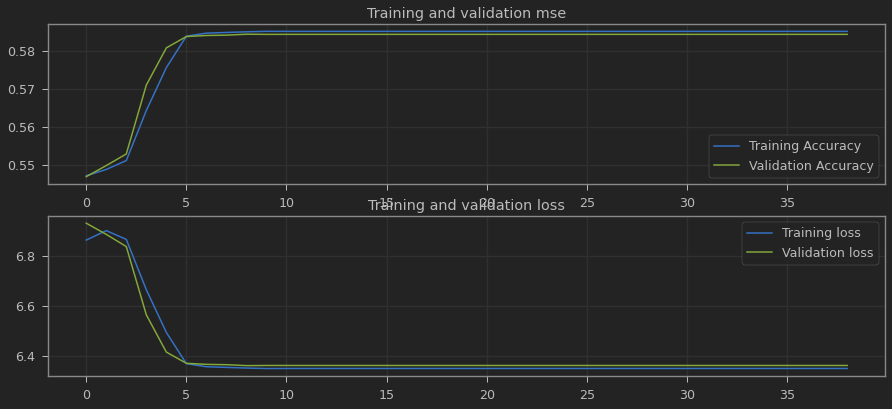

In [11]:
metrics_viewer(autoencoder_model)

### Extracting values of bottleneck

In [12]:
hidden_repr = AE.layers[0](X)

### Visualization in 3D

In [13]:
reducer = umap.UMAP(random_state = 42)
reducer.fit(hidden_repr)
embedding = reducer.transform(hidden_repr)
reducer3d = umap.UMAP(random_state = 42, n_components = 3)
reducer3d.fit(hidden_repr)
embedding3d = reducer3d.transform(hidden_repr)

In [14]:
labels = color_label_maker(hidden_repr,2)

In [15]:
bp = Babyplot()
#"customColorScale": "Dark2", "Paired", "Viridis", "Set2"
bp.add_plot(embedding3d.tolist(), "pointCloud",
           "categories", labels, {
               "size": 1.5,
               "colorScale":"custom",
               "customColorScale": "Paired",
               "folded": True,
               "showLegend": True,
               "legendTitle": "Population",
               "legendTitleFontSize": 20,
               "legendTitleFontColor":"#93c273",
               "fontColor": "#60AFEF",
               "fontSize": 15,
               "foldedEmbedding": embedding.tolist(),
           })
bp.background_color = "#2b5480"
#bp.show_ui = True
bp

<IPython.core.display.Javascript object>

## Model 2

### Loading hyper

In [16]:
BATCH_SIZE = 64
WEIGHT_DECAY = 0.001
PRUNING = 0.5
LEARNING_RATE = 0.01
first_layer = 200
second_layer = 1

### Building model

In [17]:
input_len = int(tf.shape(X_train)[1])
AE = AutoEncoder(input_len, first_layer, second_layer)
AE.build((None, input_len))

### Training model with bottleneck of 1

In [48]:
checkpoint_path = "../../Data/"
es = callbacks.EarlyStopping(patience=100, restore_best_weights=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*BATCH_SIZE)
AE.save_weights(checkpoint_path.format(epoch=0))
AE.compile(
    optimizer = keras.optimizers.Adam(LEARNING_RATE),
    loss = "BinaryCrossentropy",
    metrics = ["BinaryAccuracy"])

autoencoder_model = AE.fit(X_train, 
          X_train, 
          validation_data=(X_test, X_test),
          epochs = 250,
          callbacks=[es,cp_callback],
          verbose = 1)

Epoch 1/250








56/57 [============================>.] - ETA: 0s - loss: 5.7557 - binary_accuracy: 0.6244



57/57 [==============================] - 2s 25ms/step - loss: 5.7556 - binary_accuracy: 0.6244 - val_loss: 5.7627 - val_binary_accuracy: 0.6239
Epoch 2/250
57/57 [==============================] - 1s 23ms/step - loss: 5.7556 - binary_accuracy: 0.6244 - val_loss: 5.7627 - val_binary_accuracy: 0.6239
Epoch 3/250
57/57 [==============================] - 1s 23ms/step - loss: 5.7556 - binary_accuracy: 0.6244 - val_loss: 5.7627 - val_binary_accuracy: 0.6239
Epoch 4/250
57/57 [==============================] - 1s 23ms/step - loss: 5.7556 - binary_accuracy: 0.6244 - val_loss: 5.7627 - val_binary_accuracy: 0.6239
Epoch 5/250
57/57 [==============================] - 1s 23ms/step - loss: 5.7556 - binary_accuracy: 0.6244 - val_loss: 5.7627 - val_binary_accuracy: 0.6239
Epoch 6/250
34/57 [================>.............] - ETA: 0s - loss: 5.7538 - binary_accuracy: 0.6245
Epoch 00006: savi

Epoch 46/250
57/57 [==============================] - 1s 23ms/step - loss: 5.7556 - binary_accuracy: 0.6244 - val_loss: 5.7627 - val_binary_accuracy: 0.6239
Epoch 47/250
57/57 [==============================] - 1s 23ms/step - loss: 5.7556 - binary_accuracy: 0.6244 - val_loss: 5.7627 - val_binary_accuracy: 0.6239
Epoch 48/250
57/57 [==============================] - 1s 23ms/step - loss: 5.7556 - binary_accuracy: 0.6244 - val_loss: 5.7627 - val_binary_accuracy: 0.6239
Epoch 49/250
57/57 [==============================] - 1s 24ms/step - loss: 5.7556 - binary_accuracy: 0.6244 - val_loss: 5.7627 - val_binary_accuracy: 0.6239
Epoch 50/250
57/57 [==============================] - 1s 24ms/step - loss: 5.7556 - binary_accuracy: 0.6244 - val_loss: 5.7627 - val_binary_accuracy: 0.6239
Epoch 51/250
30/57 [==============>...............] - ETA: 0s - loss: 5.7528 - binary_accuracy: 0.6246
Epoch 00051: saving model to ../../Data/
57/57 [==============================] - 1s 25ms/step - loss: 5.7556 - 

57/57 [==============================] - 1s 24ms/step - loss: 5.7556 - binary_accuracy: 0.6244 - val_loss: 5.7627 - val_binary_accuracy: 0.6239
Epoch 92/250
57/57 [==============================] - 1s 24ms/step - loss: 5.7556 - binary_accuracy: 0.6244 - val_loss: 5.7627 - val_binary_accuracy: 0.6239
Epoch 93/250
57/57 [==============================] - 1s 24ms/step - loss: 5.7556 - binary_accuracy: 0.6244 - val_loss: 5.7627 - val_binary_accuracy: 0.6239
Epoch 94/250
57/57 [==============================] - 1s 24ms/step - loss: 5.7556 - binary_accuracy: 0.6244 - val_loss: 5.7627 - val_binary_accuracy: 0.6239
Epoch 95/250
57/57 [==============================] - 1s 24ms/step - loss: 5.7556 - binary_accuracy: 0.6244 - val_loss: 5.7627 - val_binary_accuracy: 0.6239
Epoch 96/250
24/57 [===========>..................] - ETA: 0s - loss: 5.7529 - binary_accuracy: 0.6246
Epoch 00096: saving model to ../../Data/
57/57 [==============================] - 1s 25ms/step - loss: 5.7556 - binary_accura

### Plotting metrics

<module 'matplotlib.pyplot' from '/home/mat2m10/.pyenv/versions/3.8.12/envs/ctg/lib/python3.8/site-packages/matplotlib/pyplot.py'>

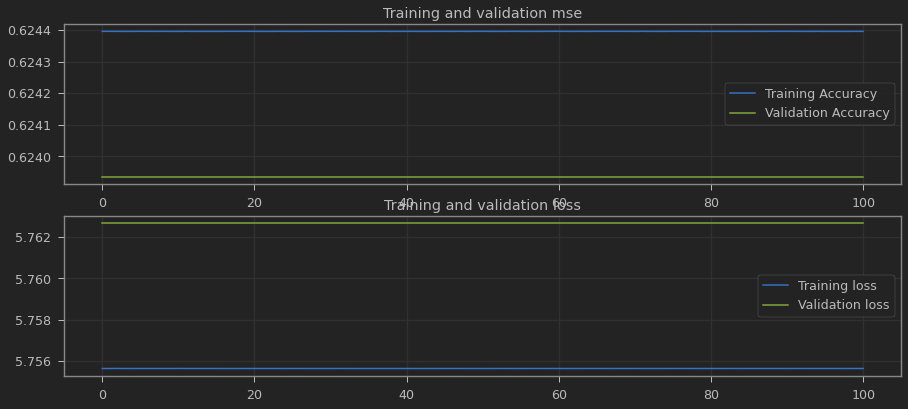

In [49]:
metrics_viewer(autoencoder_model)

### Extracting values of bottleneck

In [50]:
hidden_repr = AE.layers[0](X)

In [51]:
x = np.array(hidden_repr)

In [52]:
x1 = x[0:int(len(x)/2)]
x2 = x[int(len(x)/2):]

In [53]:
x1[:,0]

array([1447.1141, 1436.7454, 1505.9966, 1444.695 , 1402.6614, 1392.5272,
       1452.5756, 1476.4987, 1447.1395, 1437.0485, 1431.2365, 1399.173 ,
       1424.0282, 1465.9684, 1453.4868, 1404.3212, 1464.184 , 1497.8052,
       1464.2557, 1481.1442, 1400.4625, 1400.7397, 1450.1863, 1445.3568,
       1479.3218, 1416.6368, 1433.8429, 1432.3861, 1405.0348, 1435.9856,
       1450.5734, 1441.2753, 1466.2124, 1361.5513, 1475.9014, 1464.8345,
       1417.9265, 1458.6727, 1417.55  , 1427.2634, 1452.5197, 1460.2101,
       1422.1718, 1418.5905, 1500.163 , 1408.0529, 1468.3757, 1492.9818,
       1490.6879, 1628.3112, 1410.6078, 1447.9066, 1433.8005, 1445.5553,
       1476.3329, 1434.9508, 1421.268 , 1448.1049, 1459.7804, 1504.205 ,
       1423.3292, 1443.5123, 1500.8859, 1425.4867, 1467.8   , 1417.7947,
       1500.9893, 1460.0157, 1439.5497, 1468.7274, 1426.9537, 1435.7764,
       1437.9342, 1454.5897, 1470.4882, 1391.8065, 1389.7528, 1420.0022,
       1423.1904, 1470.137 , 1390.8926, 1404.9545, 

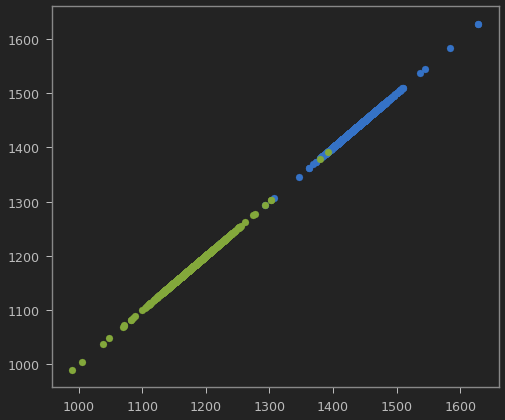

In [54]:
try:
    plt.scatter(x1[:,0], x1[:,1])
    plt.scatter(x2[:,0], x2[:,1])
    plt.show
except:
    plt.scatter(x1, x1)
    plt.scatter(x2, x2)

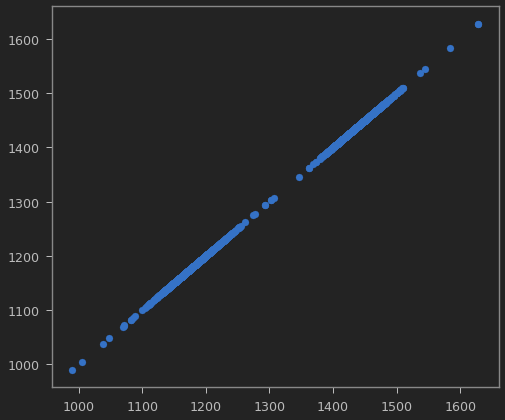

In [55]:
plt.scatter(x, x)

In [56]:
#Import required module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 3)
 
#predict the labels of clusters.
label = kmeans.fit_predict(x)
 
print(label)

[1 1 1 ... 2 2 0]


In [57]:
abs(x)

array([[1447.1141],
       [1436.7454],
       [1505.9966],
       ...,
       [1198.8822],
       [1189.914 ],
       [1160.7916]], dtype=float32)

In [58]:
data["first_component"] = x

In [59]:
data

,IID,Pheno,Geno,State,first_component
0,0pop1,0,"[2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",pop1healthy,1447.114136
1,1pop1,1,"[0, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, ...",pop1sick,1436.745361
2,2pop1,1,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",pop1sick,1505.996582
3,3pop1,1,"[2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, ...",pop1sick,1444.694946
4,4pop1,1,"[2, 0, 2, 1, 2, 2, 2, 0, 2, 2, 2, 1, 2, 1, 2, ...",pop1sick,1402.661377
...,...,...,...,...,...
1995,995pop2,1,"[0, 1, 2, 1, 1, 1, 1, 0, 0, 1, 2, 2, 0, 0, 0, ...",pop2sick,1179.405762
1996,996pop2,0,"[1, 1, 1, 0, 1, 2, 0, 0, 0, 1, 2, 1, 1, 0, 2, ...",pop2healthy,1175.920288
1997,997pop2,0,"[0, 2, 1, 1, 2, 0, 1, 2, 0, 2, 1, 1, 1, 1, 1, ...",pop2healthy,1198.882202
1998,998pop2,0,"[2, 2, 0, 0, 2, 1, 1, 0, 2, 0, 1, 1, 1, 0, 0, ...",pop2healthy,1189.913940


In [60]:
data_sorted = data.sort_values(by=['first_component'])
data_sorted

,IID,Pheno,Geno,State,first_component
1949,949pop2,0,"[1, 1, 1, 2, 2, 1, 1, 2, 0, 0, 2, 0, 1, 1, 0, ...",pop2healthy,990.327698
1026,26pop2,0,"[1, 1, 1, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1, 0, 1, ...",pop2healthy,1004.859619
1042,42pop2,0,"[2, 0, 1, 0, 2, 1, 1, 0, 2, 0, 1, 0, 1, 0, 1, ...",pop2healthy,1037.689819
1260,260pop2,0,"[1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 2, 0, 2, 0, 1, ...",pop2healthy,1047.962891
1522,522pop2,0,"[0, 0, 1, 1, 1, 1, 1, 2, 1, 0, 0, 1, 0, 0, 2, ...",pop2healthy,1069.550903
...,...,...,...,...,...
967,967pop1,1,"[2, 2, 2, 0, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, ...",pop1sick,1536.987671
164,164pop1,1,"[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, ...",pop1sick,1545.040039
739,739pop1,1,"[2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",pop1sick,1583.822144
49,49pop1,1,"[2, 2, 2, 1, 0, 1, 1, 2, 2, 1, 1, 0, 2, 2, 2, ...",pop1sick,1628.311157


In [169]:
test = np.array(data_sorted['Geno'].to_list())[:,-1] - 1

In [170]:
major = np.where(test == -1, 0, test)
minor = np.where(test == 1, 0, test)
major

array([0, 0, 1, ..., 0, 0, 0])

In [171]:
minor

array([-1, -1,  0, ..., -1, -1, -1])

In [172]:
test

array([-1, -1,  1, ..., -1, -1, -1])

In [173]:
x_axis = np.zeros(len(test))
x_axis

array([0., 0., 0., ..., 0., 0., 0.])

In [174]:
x_axis = np.array(range(0, len(test), 1))
x_axis

array([   0,    1,    2, ..., 1997, 1998, 1999])

<function matplotlib.pyplot.show(close=None, block=None)>

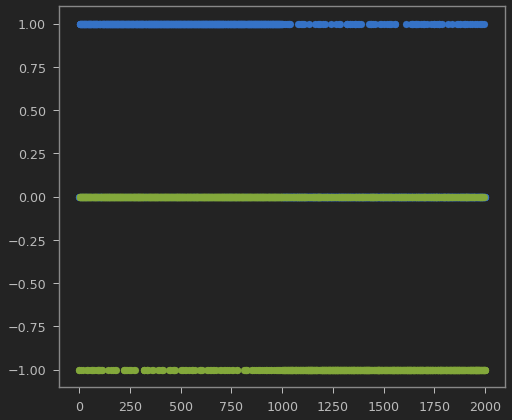

In [175]:
plt.scatter(x_axis, major)
plt.scatter(x_axis, minor)
plt.show

In [176]:
test

array([-1, -1,  1, ..., -1, -1, -1])

In [177]:
nr_splits = 16

In [178]:
arrays = np.split(test, nr_splits)


In [181]:
array_sums = []
for array in arrays:
    array_sums.append(sum(array)/len(array))
array_sums

[0.56,
 0.744,
 0.712,
 0.752,
 0.704,
 0.704,
 0.696,
 0.632,
 -0.376,
 -0.584,
 -0.56,
 -0.504,
 -0.56,
 -0.472,
 -0.576,
 -0.536]

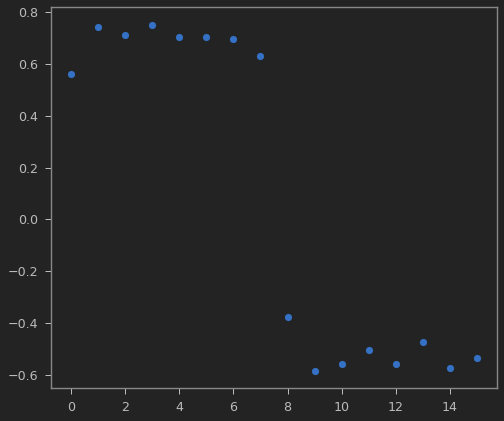

In [182]:
plt.scatter(x_axis[0:nr_splits], array_sums)

In [183]:
q + (1 - q) = 0.6

SyntaxError: cannot assign to operator (2532353518.py, line 1)